导包

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math

获取主数据集
test_data 为不可见数据集

In [50]:
data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')
data['isCancerous'] = data['isCancerous'].astype(str)
data['cellType'] = data['cellType'].astype(str)
undivided_train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(undivided_train_data, test_size=0.2, random_state=42)

([0, 1], [Text(0, 0, '0'), Text(1, 0, '1')])

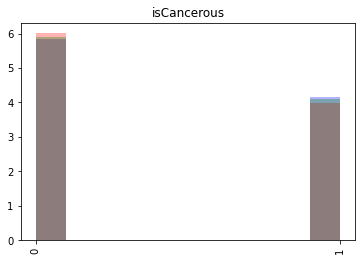

In [51]:
plt.hist(train_data['isCancerous'], alpha=0.3, color='b', label='Train', density=True)
plt.hist(test_data['isCancerous'], alpha=0.3, color='r', label='Test',  density=True)
plt.hist(val_data['isCancerous'], alpha=0.3, color='g', label='Val',  density=True)
plt.title('isCancerous')
plt.xticks(rotation='vertical')

([0, 1, 2, 3],
 [Text(0, 0, '1'), Text(1, 0, '0'), Text(2, 0, '2'), Text(3, 0, '3')])

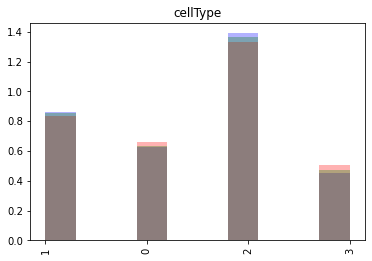

In [52]:
plt.hist(train_data['cellType'], alpha=0.3, color='b', label='Train', density=True)
plt.hist(test_data['cellType'], alpha=0.3, color='r', label='Test',  density=True)
plt.hist(val_data['cellType'], alpha=0.3, color='g', density=True)
plt.title('cellType')
plt.xticks(rotation='vertical')

In [53]:
class_samples_isCancerous = train_data['isCancerous'].value_counts()
total_samples = np.sum(class_samples_isCancerous)
class_weights_isCancerous = total_samples / class_samples_isCancerous
class_weight_dict_isCancerous = {int(k): v for k, v in class_weights_isCancerous.to_dict().items()}

class_samples_cellType = train_data['cellType'].value_counts()
total_samples = np.sum(class_samples_cellType)
class_weights_cellType = total_samples / class_samples_cellType
class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}

In [54]:
batch_size = 32
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_isCancerous_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

val_isCancerous_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

test_isCancerous_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

Found 6332 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


In [55]:
train_cellType_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

val_cellType_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

test_cellType_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 6332 validated image filenames belonging to 4 classes.
Found 1584 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


两层卷积一层池化，32，64。两层512感知器。

In [89]:
input_shape = (27, 27, 3)
num_classes = 4
l2_coeff = 0.01

model_binary = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_binary.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_90 (Bat  (None, 27, 27, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_61 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_91 (Bat  (None, 25, 25, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                     

In [113]:
model_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model_categorical.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_120 (Ba  (None, 27, 27, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_81 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_121 (Ba  (None, 25, 25, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                     

In [114]:
model_binary.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model_categorical.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005), metrics=['accuracy'])

In [55]:
epochs = 100
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-15)
history_binary = model_binary.fit(
    train_isCancerous_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_isCancerous_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_isCancerous
    , callbacks=[lr_reducer]
)

Epoch 1/100
197/197 [==============================] - 10s 47ms/step - loss: 14.5660 - accuracy: 0.8124 - val_loss: 14.6045 - val_accuracy: 0.4114 - lr: 1.0000e-04
Epoch 2/100
197/197 [==============================] - 8s 41ms/step - loss: 13.2736 - accuracy: 0.8437 - val_loss: 12.6382 - val_accuracy: 0.6971 - lr: 1.0000e-04
Epoch 3/100
197/197 [==============================] - 8s 42ms/step - loss: 12.2033 - accuracy: 0.8554 - val_loss: 11.4967 - val_accuracy: 0.7883 - lr: 1.0000e-04
Epoch 4/100
197/197 [==============================] - 9s 44ms/step - loss: 11.2488 - accuracy: 0.8630 - val_loss: 10.4482 - val_accuracy: 0.8807 - lr: 1.0000e-04
Epoch 5/100
197/197 [==============================] - 9s 44ms/step - loss: 10.3964 - accuracy: 0.8681 - val_loss: 9.6345 - val_accuracy: 0.8865 - lr: 1.0000e-04
Epoch 6/100
197/197 [==============================] - 9s 45ms/step - loss: 9.6395 - accuracy: 0.8678 - val_loss: 8.9217 - val_accuracy: 0.8897 - lr: 1.0000e-04
Epoch 7/100
197/197 [===

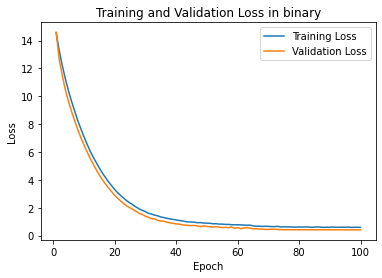

In [56]:
train_loss = history_binary.history['loss']
val_loss = history_binary.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in binary')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

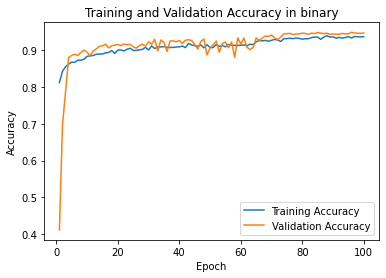

In [57]:
train_accuracy = history_binary.history['accuracy']
val_accuracy = history_binary.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in binary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

评估不可见数据集的表现

In [64]:
loss, accuracy = model_binary.evaluate(test_isCancerous_generator)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

62/62 [==============================] - 2s 28ms/step - loss: 0.4236 - accuracy: 0.9414
Loss: 0.4236, Accuracy: 0.9414


# 训练多分类

In [115]:
epochs = 100
history_categorical = model_categorical.fit(
    train_cellType_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_cellType_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_cellType
    , callbacks=[lr_reducer]
)

Epoch 1/100
197/197 [==============================] - 16s 72ms/step - loss: 19.2293 - accuracy: 0.5692 - val_loss: 17.2923 - val_accuracy: 0.4088 - lr: 5.0000e-04
Epoch 2/100
197/197 [==============================] - 12s 61ms/step - loss: 17.1087 - accuracy: 0.6254 - val_loss: 14.5520 - val_accuracy: 0.4407 - lr: 5.0000e-04
Epoch 3/100
197/197 [==============================] - 12s 62ms/step - loss: 15.4242 - accuracy: 0.6479 - val_loss: 11.8550 - val_accuracy: 0.6339 - lr: 5.0000e-04
Epoch 4/100
197/197 [==============================] - 12s 61ms/step - loss: 13.8270 - accuracy: 0.6614 - val_loss: 10.7854 - val_accuracy: 0.6467 - lr: 5.0000e-04
Epoch 5/100
197/197 [==============================] - 12s 61ms/step - loss: 12.2969 - accuracy: 0.6843 - val_loss: 8.9642 - val_accuracy: 0.7258 - lr: 5.0000e-04
Epoch 6/100
197/197 [==============================] - 12s 61ms/step - loss: 10.9253 - accuracy: 0.6908 - val_loss: 8.4763 - val_accuracy: 0.4184 - lr: 5.0000e-04
Epoch 7/100
197/19

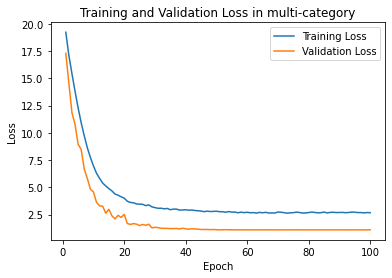

In [116]:
train_loss = history_categorical.history['loss']
val_loss = history_categorical.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in multi-category')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

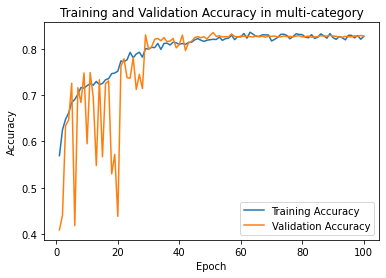

In [117]:
train_accuracy = history_categorical.history['accuracy']
val_accuracy = history_categorical.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in multi-category')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [118]:
# # 预测
# predictions = model_categorical.predict(test_cellType_generator)
#
# # 获取预测标签
# predicted_labels = np.argmax(predictions, axis=-1)
#
# # 计算准确度
# true_labels = test_cellType_generator.classes
# accuracy = accuracy_score(true_labels, predicted_labels)
# print(f"Accuracy: {accuracy}")
#
# # 计算损失
# y_true = tf.keras.utils.to_categorical(true_labels, num_classes=4) # 根据您的类别数量更改 num_classes
# loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, predictions))
# print(f"Loss: {loss}")

loss, accuracy = model_categorical.evaluate(test_cellType_generator)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

62/62 [==============================] - 3s 52ms/step - loss: 1.1483 - accuracy: 0.8172
Loss: 1.1483, Accuracy: 0.8172


In [119]:
model_categorical.save('saved_model/model_categorical')

INFO:tensorflow:Assets written to: saved_model/model_categorical/assets


INFO:tensorflow:Assets written to: saved_model/model_categorical/assets


# DI/HD 使用data_labels_extraData对多分类的模型进行增强
通过半监督学习。我们将采用UDA。
首先先获取额外的数据集并且进行相关处理。
我们从数据集可以观察到，没有癌症在多分类中为2。所以我们可以将不是癌症的样本之间指定其多分类的类别为2.

In [65]:
model_categorical = tf.keras.models.load_model('saved_model/model_categorical')
data_extra = pd.read_csv('./Image_classification_data/data_labels_extraData.csv')
data_extra['isCancerous'] = data_extra['isCancerous'].astype(str)
# data_extra['cellType'] = np.nan
# data_extra.loc[data_extra['isCancerous'] == '1', 'cellType'] = 2
# data_extra_unlabeled = data_extra[data_extra['cellType'].isna()]
# data_extra_labeled = data_extra[data_extra['cellType'] == 2]
# undivided_train_data = pd.concat([undivided_train_data, data_extra_labeled], axis=0).reset_index(drop=True)
# undivided_train_data['cellType'] = undivided_train_data['cellType'].astype(int)
# train_data, val_data = train_test_split(undivided_train_data, test_size=0.2, random_state=42)

In [40]:
# cellType(多分类)的比例
# class_samples_cellType = train_data['cellType'].value_counts()
# total_samples = np.sum(class_samples_cellType)
# class_weights_cellType = total_samples / class_samples_cellType
# class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}
#
# data_extra_unlabeled['isCancerous'] = data_extra_unlabeled['isCancerous'].astype(str)
# train_data['cellType'] = train_data['cellType'].astype(str)
# val_data['cellType'] = val_data['cellType'].astype(str)

/var/folders/qx/28c_j79n3zn_3rkwzsdcmn240000gn/T/ipykernel_6794/742382656.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_extra_unlabeled['isCancerous'] = data_extra_unlabeled['isCancerous'].astype(str)


重新生成新的train_generator

In [66]:
batch_size = 32
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

unlabeled_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

unlabeled_generator = unlabeled_datagen.flow_from_dataframe(
    data_extra,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous', # 我们并不关心y_col。只是为了防止报错
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_data['cellType'] = test_data['cellType'].astype(str)
validation_cellType_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 6332 validated image filenames belonging to 4 classes.
Found 10384 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 4 classes.


## UDA实现

In [67]:
# 定义数据增强策略
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
    tf.keras.layers.RandomContrast(factor=(0.8, 1.2)),
    tf.keras.layers.RandomBrightness(factor=0.1),
])

In [68]:
def apply_uda(x_batch, y_batch, x_unlabeled, model, optimizer, training=True, class_weight_dict=None, consistency_weight=1, confidence_threshold=0.5, temperature=0.5):
    x_unlabeled_augmented = None
    if x_unlabeled is not None:
        # 对无标签数据进行数据增强
        x_unlabeled_augmented = data_augmentation(x_unlabeled)

    # 计算模型在原始无标签数据和增强无标签数据上的输出
    with tf.GradientTape() as tape:
        y_pred_labeled = model(x_batch)
        if x_unlabeled is not None:
            y_pred_unlabeled = model(x_unlabeled)
            y_pred_unlabeled_augmented = model(x_unlabeled_augmented)

            # Sharpening Predictions
            y_pred_unlabeled = tf.nn.softmax(y_pred_unlabeled / temperature, axis=-1)
            y_pred_unlabeled_augmented = tf.nn.softmax(y_pred_unlabeled_augmented / temperature, axis=-1)

            # Confidence-based masking
            max_probs = tf.reduce_max(y_pred_unlabeled, axis=-1)
            mask = max_probs > confidence_threshold
            y_pred_unlabeled = tf.boolean_mask(y_pred_unlabeled, mask)
            y_pred_unlabeled_augmented = tf.boolean_mask(y_pred_unlabeled_augmented, mask)

        # 计算有监督损失
        # 如果是训练并且给定了类别权重，则根据权重计算损失。
        if class_weight_dict is not None and training:
            sample_weights = tf.gather(class_weight_dict, tf.argmax(y_batch, axis=-1))
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch, y_pred_labeled) * sample_weights)
        else:
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch, y_pred_labeled))

        # 如果提供了无标签数据，则计算一致性损失，(半监督学习)
        if x_unlabeled is not None:
            consistency_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_pred_unlabeled, y_pred_unlabeled_augmented))
            total_loss = supervised_loss + consistency_weight * consistency_loss
        else:
            total_loss = supervised_loss

        # 计算准确度
        accuracy = tf.keras.metrics.categorical_accuracy(y_batch, y_pred_labeled)

        if training:
            # 反向传播和优化
            grads = tape.gradient(total_loss, model_categorical.trainable_variables)
            optimizer.apply_gradients(zip(grads, model_categorical.trainable_variables))
    return total_loss, supervised_loss, consistency_loss if x_unlabeled is not None else None, accuracy

### 训练半监督

In [69]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-08)
epochs = 20
min_val_loss = float('inf')
num_epochs_no_improvement = 0
current_learning_rate = optimizer.learning_rate.numpy()
history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    total_loss = 0
    total_supervised_loss = 0
    total_consistency_loss = 0
    total_accuracy = 0
    steps = 0

    total_batches = math.ceil(len(train_data) / batch_size)
    with tqdm(total=total_batches, desc="Training", ncols=100) as progress_bar:
        for (x_batch, y_batch), (x_unlabeled, _) in zip(train_generator, unlabeled_generator):
            progress_bar.update(1)
            loss, supervised_loss, consistency_loss, accuracy = apply_uda(x_batch,
                                                                          y_batch,
                                                                          x_unlabeled,
                                                                          model_categorical,
                                                                          optimizer,
                                                                          class_weight_dict_cellType)
            total_loss += loss
            total_supervised_loss += supervised_loss
            total_consistency_loss += consistency_loss
            total_accuracy += tf.reduce_mean(accuracy)
            steps += 1
            # 检查是否已经处理了所有批次
            if steps * batch_size >= len(train_data):
                break

        # 计算并打印平均损失和准确率
        avg_loss = total_loss / steps
        avg_supervised_loss = total_supervised_loss / steps
        avg_consistency_loss = total_consistency_loss / steps
        avg_accuracy = total_accuracy / steps
        history["loss"].append(avg_loss.numpy())
        history["accuracy"].append(avg_accuracy.numpy())
        print(f" - loss: {avg_loss.numpy():.4f}, supervised_loss: {avg_supervised_loss.numpy():.4f}, consistency_loss: {avg_consistency_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}")

    total_loss = 0
    total_accuracy = 0
    steps = 0
    for x_batch, y_batch in validation_cellType_generator:
        loss, _, _, accuracy = apply_uda(x_batch, y_batch, None, model_categorical, optimizer, False)
        total_loss += loss
        total_accuracy += tf.reduce_mean(accuracy)
        steps += 1

        if steps * batch_size >= len(test_data):
            break

    avg_loss = total_loss / steps
    avg_accuracy = total_accuracy / steps
    history["val_loss"].append(avg_loss.numpy())
    history["val_accuracy"].append(avg_accuracy.numpy())
    print(f"Validation set： - loss: {avg_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}, learning rate: {current_learning_rate}")

    # 检查是否需要更新学习率
    if avg_loss < min_val_loss:
        min_val_loss = loss
        num_epochs_no_improvement = 0
    else:
        num_epochs_no_improvement += 1

    if num_epochs_no_improvement >= 3:
        current_learning_rate *= np.sqrt(0.1)
        current_learning_rate = max(current_learning_rate, 0.5e-15)
        optimizer.learning_rate.assign(current_learning_rate)
        num_epochs_no_improvement = 0

Epoch 1/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:30<00:00,  6.59it/s]


 - loss: 0.5180, supervised_loss: 0.4168, consistency_loss: 0.1012, accuracy: 0.8518
Validation set： - loss: 0.4440, accuracy: 0.8317, learning rate: 9.99999993922529e-09
Epoch 2/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:28<00:00,  7.05it/s]


 - loss: 0.5153, supervised_loss: 0.4142, consistency_loss: 0.1011, accuracy: 0.8515
Validation set： - loss: 0.4582, accuracy: 0.8216, learning rate: 9.99999993922529e-09
Epoch 3/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:30<00:00,  6.41it/s]


 - loss: 0.5108, supervised_loss: 0.4100, consistency_loss: 0.1009, accuracy: 0.8507
Validation set： - loss: 0.4210, accuracy: 0.8352, learning rate: 9.99999993922529e-09
Epoch 4/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:30<00:00,  6.59it/s]


 - loss: 0.5148, supervised_loss: 0.4139, consistency_loss: 0.1009, accuracy: 0.8479
Validation set： - loss: 0.4629, accuracy: 0.8221, learning rate: 9.99999993922529e-09
Epoch 5/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:29<00:00,  6.76it/s]


 - loss: 0.5154, supervised_loss: 0.4148, consistency_loss: 0.1006, accuracy: 0.8475
Validation set： - loss: 0.4442, accuracy: 0.8286, learning rate: 9.99999993922529e-09
Epoch 6/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:29<00:00,  6.78it/s]


 - loss: 0.5139, supervised_loss: 0.4158, consistency_loss: 0.0981, accuracy: 0.8490
Validation set： - loss: 0.4407, accuracy: 0.8291, learning rate: 3.162277640949729e-09
Epoch 7/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:29<00:00,  6.66it/s]


 - loss: 0.5088, supervised_loss: 0.4097, consistency_loss: 0.0991, accuracy: 0.8563
Validation set： - loss: 0.4394, accuracy: 0.8311, learning rate: 3.162277640949729e-09
Epoch 8/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:27<00:00,  7.09it/s]


 - loss: 0.5106, supervised_loss: 0.4115, consistency_loss: 0.0992, accuracy: 0.8496
Validation set： - loss: 0.4507, accuracy: 0.8281, learning rate: 3.162277640949729e-09
Epoch 9/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:29<00:00,  6.61it/s]


 - loss: 0.5111, supervised_loss: 0.4119, consistency_loss: 0.0993, accuracy: 0.8491
Validation set： - loss: 0.4554, accuracy: 0.8276, learning rate: 9.999999939225292e-10
Epoch 10/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:29<00:00,  6.65it/s]


 - loss: 0.5129, supervised_loss: 0.4131, consistency_loss: 0.0998, accuracy: 0.8487
Validation set： - loss: 0.4343, accuracy: 0.8286, learning rate: 9.999999939225292e-10
Epoch 11/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:28<00:00,  6.98it/s]


 - loss: 0.5037, supervised_loss: 0.4073, consistency_loss: 0.0963, accuracy: 0.8506
Validation set： - loss: 0.4584, accuracy: 0.8251, learning rate: 9.999999939225292e-10
Epoch 12/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:28<00:00,  6.86it/s]


 - loss: 0.5138, supervised_loss: 0.4144, consistency_loss: 0.0995, accuracy: 0.8486
Validation set： - loss: 0.4308, accuracy: 0.8377, learning rate: 3.1622776409497293e-10
Epoch 13/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:30<00:00,  6.42it/s]


 - loss: 0.5173, supervised_loss: 0.4176, consistency_loss: 0.0997, accuracy: 0.8484
Validation set： - loss: 0.4582, accuracy: 0.8236, learning rate: 3.1622776409497293e-10
Epoch 14/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:29<00:00,  6.81it/s]


 - loss: 0.5154, supervised_loss: 0.4170, consistency_loss: 0.0984, accuracy: 0.8527
Validation set： - loss: 0.4410, accuracy: 0.8301, learning rate: 3.1622776409497293e-10
Epoch 15/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:29<00:00,  6.77it/s]


 - loss: 0.5072, supervised_loss: 0.4074, consistency_loss: 0.0998, accuracy: 0.8579
Validation set： - loss: 0.4278, accuracy: 0.8342, learning rate: 9.999999939225292e-11
Epoch 16/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:29<00:00,  6.61it/s]


 - loss: 0.5112, supervised_loss: 0.4120, consistency_loss: 0.0992, accuracy: 0.8518
Validation set： - loss: 0.4616, accuracy: 0.8261, learning rate: 9.999999939225292e-11
Epoch 17/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:30<00:00,  6.45it/s]


 - loss: 0.5154, supervised_loss: 0.4158, consistency_loss: 0.0997, accuracy: 0.8504
Validation set： - loss: 0.4360, accuracy: 0.8337, learning rate: 9.999999939225292e-11
Epoch 18/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:28<00:00,  6.98it/s]


 - loss: 0.5134, supervised_loss: 0.4139, consistency_loss: 0.0995, accuracy: 0.8513
Validation set： - loss: 0.4499, accuracy: 0.8246, learning rate: 3.162277640949729e-11
Epoch 19/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:27<00:00,  7.18it/s]


 - loss: 0.5103, supervised_loss: 0.4136, consistency_loss: 0.0966, accuracy: 0.8526
Validation set： - loss: 0.4431, accuracy: 0.8311, learning rate: 3.162277640949729e-11
Epoch 20/20


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:27<00:00,  7.09it/s]


 - loss: 0.5137, supervised_loss: 0.4159, consistency_loss: 0.0977, accuracy: 0.8491
Validation set： - loss: 0.4415, accuracy: 0.8301, learning rate: 3.162277640949729e-11


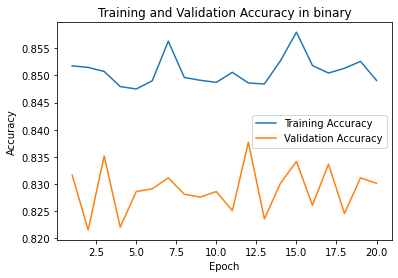

In [70]:
train_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in binary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [71]:
loss, accuracy = model_categorical.evaluate(test_cellType_generator)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

62/62 [==============================] - 2s 24ms/step - loss: 1.1442 - accuracy: 0.8167
Loss: 1.1442, Accuracy: 0.8167
